# Absorption project

## Basic parameters, data and python libraries

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
T0 = 293.15;     #temperature scale for the calibrated functions
Patm = 101325.0; #atmospheric pressure
T01 = 273.16;    #triple point temperature
KelvinConversion = 273.15;

In [3]:
other_materials_ai = np.loadtxt("other_materials_ai.txt",dtype=float)

In [4]:
with open("other_materials_names.txt", "r") as textfile:
    other_materials_names = textfile.readlines()
textfile.close()
iline=0;
for line in other_materials_names:
    other_materials_names[iline] = other_materials_names[iline].replace('\n', '')
    iline += 1;

## Air absorption functions, original

In [5]:
#classical absorption, T in k
def classical(TKelvin, f):
  return 868.6*1.84e-11*math.pow(TKelvin/T0,1./2.)*f*f;

In [6]:
#Nitrogen relaxation frequency
def FrN(TKelvin, h, P):
  return P/Patm*(9 + 280*h*math.exp(-4.17*(math.pow(TKelvin/T0,-1./3.) - 1)))*math.pow(TKelvin/T0,-1./2.);

In [7]:
#Oxygen relaxation frequency
def FrO(h, P):
  return P/Patm*(24 + 4.04e4*h*(0.02+h)/(0.391+h));

In [8]:
#Water vapour saturation pressure
def psat(TKelvin):
  return Patm*math.pow(10,-6.8346*math.pow(T01/TKelvin,1.261) + 4.6151);

In [9]:
#Absolute humidity
def habs(hrel, TKelvin, P):
  return hrel*psat(TKelvin)/P;

In [10]:
#Nitrogen absorption
def Nit(TKelvin, h, P, f):
  frn = FrN(TKelvin,h,P);
  return  868.6*0.1068*math.exp(-3352./TKelvin)*math.pow(TKelvin/T0,-5./2.)*frn * f*f/(frn*frn + f*f);

In [11]:
#Oxygen absorption
def Oxyg(TKelvin, h, P, f):
  fro = FrO(h,P);
  return  868.6*0.01275*math.exp(-2239.1/TKelvin)*math.pow(TKelvin/T0,-5./2.)*fro * f*f/(fro*fro+f*f);

In [12]:
#Total air absorption, this function is not needed actually
def AlphaAir(TKelvin, h, P, f):
  return classical(TKelvin,f) + Nit(TKelvin,h,P,f) + Oxyg(TKelvin,h,P,f);

## Seawater absorption functions, original

In [13]:
#Sound speed in water
def csound(TCelsius, Salinity, Depth, pH):
  return 1412 + 3.21*TCelsius + 1.19*Salinity + 0.0167*Depth;

In [14]:
#Water absorption frequency scale, to make formulas simpler, frequencies in kHz here
def FrW(TCelsius, Salinity, Depth, pH):
  return 1/(1 - 3.83e-5*Depth + 4.9e-10*Depth*Depth);

In [15]:
#Boric acid relaxation frequency, frequencies in kHz here
def FrB(TCelsius, Salinity, Depth, pH):
  TKelvin = TCelsius + KelvinConversion;
  return 2.8*math.sqrt(Salinity/35)*pow(10,4-1245/TKelvin);

In [16]:
#Magnesium sulphate relaxation frequency, frequencies in kHz here
def FrM(TCelsius, Salinity, Depth, pH):
  TKelvin = TCelsius + KelvinConversion;
  return 8.17*math.pow(10,8-1990/TKelvin)/(1 + 0.0018*(Salinity - 35));

In [17]:
#Classical absorption in water, frequencies in kHz here
def Water(TCelsius, Salinity, Depth, pH, f):
  frw = FrW(TCelsius, Salinity, Depth, pH);
  cw = -1;
  if(TCelsius<=20): cw = 4.937e-4 - 2.590e-5*TCelsius + 9.11e-7*TCelsius*TCelsius - 1.50e-8*TCelsius*TCelsius*TCelsius;
  else:             cw = 3.964e-4 - 1.146e-5*TCelsius + 1.45e-7*TCelsius*TCelsius - 6.50e-10*TCelsius*TCelsius*TCelsius;
  return cw*f*f/(frw*frw);

In [18]:
#Magnesium sulphate absorption, frequencies in kHz here
def Magsulf(TCelsius, Salinity, Depth, pH, f):
  frm = FrM(TCelsius, Salinity, Depth, pH);
  c = csound(TCelsius, Salinity, Depth, pH);
  return 21.44*Salinity/c*(1+0.025*TCelsius)*(1-1.37e-4*Depth+ 6.2e-9*Depth*Depth)*frm*f*f/(frm*frm+f*f);

In [19]:
#Boric acid absorption, frequencies in kHz here
def Boric(TCelsius, Salinity, Depth, pH, f):
  frb = FrB(TCelsius, Salinity, Depth, pH);
  c = csound(TCelsius, Salinity, Depth, pH);
  return (8.86/c)*math.pow(10,0.78*pH-5)*frb*f*f/(frb*frb+f*f);

In [20]:
#Total water absorption, frequencies in kHz here
def AlphaWater(TCelsius, Salinity, Depth, pH, f):
  return Water(TCelsius,Salinity,Depth,pH,f) + Magsulf(TCelsius,Salinity,Depth,pH,f) + Boric(TCelsius,Salinity,Depth,pH,f);

## Setup formula parameters for water and air

In [21]:
#Global air parameters
flim1a=-1; flim2a=-1; flim3a=-1; flim4a=-1;
n1a=-1; n2a=-1; n3a=-1; n4a=-1; n5a=-1;
a1a=-1; a2a=-1; a3a=-1; a4a=-1; a5a=-1
air_setup = False;

#Global water parameters
flim1w=-1; flim2w=-1; flim3w=-1; flim4w=-1;
n1w=-1; n2w=-1; n3w=-1; n4w=-1; n5w=-1;
a1w=-1; a2w=-1; a3w=-1; a4w=-1; a5w=-1
water_setup = False;

In [22]:
def setup_parameters_air(TKelvin, Humidity, Pressure):
  global flim1a, flim2a, flim3a, flim4a;
  global n1a, n2a, n3a, n4a, n5a;
  global a1a, a2a, a3a, a4a, a5a;
  global air_setup;
    
  PPascal = Pressure * Patm;
  TCelsius = TKelvin - T01;
  hvalue = habs(Humidity,TKelvin,PPascal);
  
  #Basic parameters for the first estimate
  fN = FrN(TKelvin,hvalue,PPascal);
  fO = FrO(hvalue,PPascal);
  fC = 1; #fC does not appear in the formulas, but can be understood as cC -> cC/fC^2, for symmetry reasons
  
  cN = 2*Nit(TKelvin,hvalue,PPascal,fN);    #cN=2*NFunc(fN), as then f^2/(f^2+fN^2) = 1/2
  cO = 2*Oxyg(TKelvin,hvalue,PPascal,fO);   #cO=2*OFunc(fO), as then f^2/(f^2+fO^2) = 1/2
  cC = classical(TKelvin,fC); #cO=CFunc(fC), as then f^2=1
  
  fiNO = math.sqrt(fN*fO)*math.pow(cN/cO+fN*fN/fO/fO,0.25); #f_i for transition from N to O
  fiOC = math.sqrt(fO*fC)*math.pow(cO/cC+fO*fO/fC/fC,0.25); #f_i for transition from O to classical
  
  nNO = 4*cO*fiNO*fiNO / (cO*fiNO*fiNO + cN*fO*fO + cO*fN*fN);
  nOC = 4*cC*fiOC*fiOC / (cC*fiOC*fiOC + cO*fC*fC + cC*fO*fO);
  
  ciNO = AlphaAir(TKelvin,hvalue,PPascal,fiNO);
  ciOC = AlphaAir(TKelvin,hvalue,PPascal,fiOC);
  
  #Estimated parameters  
  flim1a = fiNO*math.pow(cN/ciNO*fiNO*fiNO/fN/fN,1.0/(nNO-2));
  flim2a = fiNO*math.pow(cO/ciNO*fiNO*fiNO/fO/fO,1.0/(nNO-2));
  flim3a = fiOC*math.pow(cO/ciOC*fiOC*fiOC/fO/fO,1.0/(nOC-2));
  flim4a = fiOC*math.pow(cC/ciOC*fiOC*fiOC/fC/fC,1.0/(nOC-2));
  
  n1a = 2;
  n2a = nNO;
  n3a = 2;
  n4a = nOC;
  n5a = 2;
  
  #Corrections based on Excel calculation
  flim1a = 0.92306*flim1a - 8.2963E-05*flim1a*flim1a; 
  flim2a = 0.90727*flim2a - 1.5649E-05*flim2a*flim2a;
  if(flim3a<0 or flim3a>20000): flim3a = 22222; #This means that if original flim3 is out of range, then do not use it
  else: flim3a = 0.89696*flim3a + 5.3452E-07*flim3a*flim3a;
  #flim4a is not relevant for the interval [20 Hz, 20 kHz], so no correction is introduced for it
  
  n1a = 1.763454532 + 0.003249811*TCelsius + 0.001091377*Humidity;
  n2a = 1.6968*n2a - 0.537*n2a*n2a;
  n3a = 1.671471966 + 0.000832291*TCelsius + 0.001112712*Humidity;
  n4a = 1.7413*n4a;
  #n5a is not relevant for the interval [20 Hz, 20 kHz], so no correction is introduced for it
  
  a1tempa = 1.96005E-05*math.exp(-0.0159*TCelsius)*math.pow(Humidity,-0.4);
  a1a = -0.83774*a1tempa + 7.52E+05*a1tempa*a1tempa + 2.35E+10*a1tempa*a1tempa*a1tempa;
  
  #Formulas for the constant prefactors ensuring continuity
  a2a = a1a*math.pow(flim1a,n1a-n2a);
  a3a = a2a*math.pow(flim2a,n2a-n3a);
  a4a = a3a*math.pow(flim3a,n3a-n4a);
  a5a = a4a*math.pow(flim4a,n4a-n5a);
  
  air_setup = True;
  print("Air setup done.");

In [23]:
#Setup parameters for water formula
def setup_parameters_water(TCelsius, Salinity, Depth, pH):
  global flim1w, flim2w, flim3w, flim4w;
  global n1w, n2w, n3w, n4w, n5w;
  global a1w, a2w, a3w, a4w, a5w;
  global water_setup;

  #Basic parameters for the first estimate
  fW = FrW(TCelsius, Salinity, Depth, pH)*1000; #in Hz
  fB = FrB(TCelsius, Salinity, Depth, pH)*1000; #in Hz
  fM = FrM(TCelsius, Salinity, Depth, pH)*1000; #in Hz

  cW =   Water(TCelsius, Salinity, Depth, pH, fW/1000);   #c=  Func(f0), as then f^2/f0^2       = 1
  cB = 2*Boric(TCelsius, Salinity, Depth, pH, fB/1000);   #c=2*Func(f0), as then f^2/(f^2+f0^2) = 1/2
  cM = 2*Magsulf(TCelsius, Salinity, Depth, pH, fM/1000); #c=2*Func(f0), as then f^2/(f^2+f0^2) = 1/2
  
  fiBM = math.sqrt(fB*fM)*math.pow(cB/cM+fB*fB/fM/fM,0.25); #f_i for transition from B to M
  fiMW = math.sqrt(fM*fW)*math.pow(cM/cW+fM*fM/fW/fW,0.25); #f_i for transition from M to W
  
  nBM = 4*cM*fiBM*fiBM / (cM*fiBM*fiBM + cB*fM*fM + cM*fB*fB);
  nMW = 4*cW*fiMW*fiMW / (cW*fiMW*fiMW + cM*fW*fW + cW*fM*fM);
  
  ciBM = AlphaWater(TCelsius, Salinity, Depth, pH, fiBM/1000); #Expects f in kHz
  ciMW = AlphaWater(TCelsius, Salinity, Depth, pH, fiMW/1000); #Expects f in kHz
  
  #Estimated parameters  
  flim1w = fiBM*pow(cB/ciBM*fiBM*fiBM/fB/fB,1.0/(nBM-2));
  flim2w = fiBM*pow(cM/ciBM*fiBM*fiBM/fM/fM,1.0/(nBM-2));
  flim3w = fiMW*pow(cM/ciMW*fiMW*fiMW/fM/fM,1.0/(nMW-2)); #Not relevant
  #flim4w = fiMW*pow(cW/ciMW*fiMW*fiMW/fW/fW,1.0/(nMW-2)); #Not relevant
  
  n1w = 2;
  n2w = nBM;
  n3w = 2;
  n4w = nMW;
  n5w = 2;

  #Estimates based on Excel calculation
  flim1w = 0.8282*flim1w + 25.818;
  flim2w = 0.7481*flim2w + 647.67;
  #flim3w and flim4w are not relevant for the interval [20 Hz, 20 kHz], hence no correction is introduced for them
  
  n1w = 1.9093 + 0.000968093*TCelsius + 0.000928211*Salinity + 4.61102e-7*TCelsius*Salinity -  9.12418e-7*Depth - 4.34584e-10*Salinity*Depth;
  n2w = 0.8716*n2w + 0.2902;
  n3w = 1.51232 - 0.000024935*Depth + 0.00661563*Salinity +  0.00219034*TCelsius - 0.000312489*TCelsius*TCelsius;
  #n4w and n5w are not relevant for the interval [20 Hz, 20 kHz], hence no correction is introduced for them
  
  a1w = 0.0000002651151*(1 - 0.040785676*TCelsius+0.0006424371*TCelsius*TCelsius)*(1-0.008556518*Salinity)*(1-0.000012658*Depth);
  
  #Formulas for the constant prefactors ensuring continuity
  a2w = a1w*pow(flim1w,n1w-n2w);
  a3w = a2w*pow(flim2w,n2w-n3w);
  a4w = a3w*pow(flim3w,n3w-n4w);
  a5w = a4w*pow(flim4w,n4w-n5w);
  
  water_setup = True;
  print("Water setup done.");

## Simplified formulas for water and air

In [24]:
#Air absorption simple formula
def air_absorption(TKelvin, Humidity, Pressure, f):
  if(not air_setup): setup_parameters_air(TKelvin, Humidity, Pressure);
  
  if(f<flim1a):   return a1a*math.pow(f,n1a);
  elif(f<flim2a): return a2a*math.pow(f,n2a);
  elif(f<flim3a): return a3a*math.pow(f,n3a);
  elif(f<flim4a): return a4a*math.pow(f,n4a);
  else:           return a5a*math.pow(f,n5a);

In [25]:
#Water absorption simple formula
def water_absorption(TCelsius, Salinity, Depth, pH, f):
  if(not water_setup): setup_parameters_water(TCelsius, Salinity, Depth, pH);

  if(f<flim1w):   return a1w*math.pow(f,n1w);
  elif(f<flim2w): return a2w*math.pow(f,n2w);
  elif(f<flim3w): return a3w*math.pow(f,n3w);
  elif(f<flim4w): return a4w*math.pow(f,n4w);
  else:           return a5w*math.pow(f,n5w);

## Simplified plots for other, construction related materials

In [26]:
NMAT = len(other_materials_names) #number of materials
NAI = 6 #len(other_materials_ai[1]) #number of a_i values for a given material

frequenciesOtherMat = [125,250,500,1000,2000,4000]

def AlphaOtherMaterial(f,nmat):
  if(nmat<0 or nmat>=NMAT): return -9999;

  irange = -1;
  for ifr in range(NAI):
    if(f<frequenciesOtherMat[ifr]):
      irange=ifr;
      break;
  if(irange==-1): irange=NAI; #this means f larger than largest frequency point
  if(irange==0): irange=1; #first range is up to 250
  if(irange>NAI-2): irange=NAI-1; #/last range is from 2000
    
  n = math.log(other_materials_ai[nmat][irange]/other_materials_ai[nmat][irange-1]) / math.log(frequenciesOtherMat[irange]/frequenciesOtherMat[irange-1]);
  c = other_materials_ai[nmat][irange]/math.pow(frequenciesOtherMat[irange],n);
  
  return c*math.pow(f,n);

## Example plots

### Air absorption

In [27]:
TKelvin=293.15
Humidity=30
Pressure=1
NFR=100;
air_setup = False;
logftab=np.linspace(math.log(20),math.log(20000),NFR);
ftab=np.exp(logftab);
asimptab=np.linspace(0,0,NFR);
aorigtab=np.linspace(0,0,NFR);
for ifr in range(NFR):
  fr = ftab[ifr]
  asimptab[ifr]=air_absorption(TKelvin, Humidity, Pressure, fr)
  PPascal = Pressure*Patm;
  aorigtab[ifr]=AlphaAir(TKelvin,habs(Humidity,TKelvin,PPascal),PPascal,fr)

Air setup done.


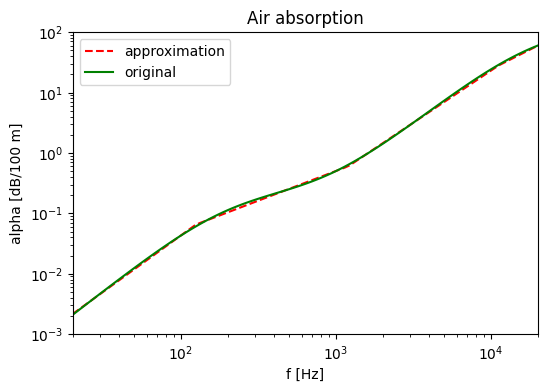

In [28]:
plt.figure(num=None, figsize=(6, 4), dpi=100, facecolor='w', edgecolor='k')
plt.title('Air absorption')
plt.xlabel('f [Hz]');
plt.ylabel('alpha [dB/100 m]');
plt.xlim(20,20000)
plt.ylim(0.001,100)
plt.loglog(ftab, asimptab, 'r--', label='approximation');
plt.loglog(ftab, aorigtab, 'g-', label='original');
plt.legend();

### Water absorption

In [29]:
TCelsius=8
Salinity=35
Depth=500
pH=8
water_setup = False;
wsimptab=np.linspace(0,0,NFR);
worigtab=np.linspace(0,0,NFR);
for ifr in range(NFR):
  fr = ftab[ifr]
  wsimptab[ifr]=water_absorption(TCelsius, Salinity, Depth, pH, fr)
  worigtab[ifr]=AlphaWater(TCelsius, Salinity, Depth, pH, fr/1000)

Water setup done.


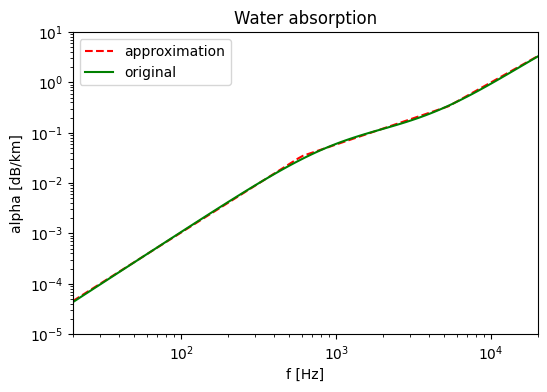

In [30]:
plt.figure(num=None, figsize=(6, 4), dpi=100, facecolor='w', edgecolor='k')
plt.title('Water absorption')
plt.xlabel('f [Hz]');
plt.ylabel('alpha [dB/km]');
plt.xlim(20,20000)
plt.ylim(0.00001,10)
plt.loglog(ftab, wsimptab, 'r--', label='approximation');
plt.loglog(ftab, worigtab, 'g-', label='original');
plt.legend();

### Other materials

In [31]:
nmat = 5; #"Smooth brickwork with flush pointing"
aothertab=np.linspace(0,0,NFR);
for ifr in range(NFR):
  fr = ftab[ifr]
  aothertab[ifr] = AlphaOtherMaterial(fr,nmat)

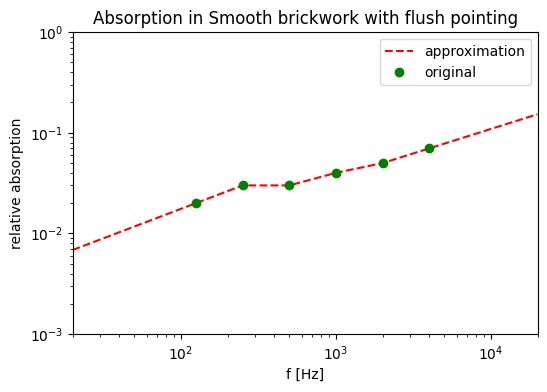

In [32]:
plt.figure(num=None, figsize=(6, 4), dpi=100, facecolor='w', edgecolor='k')
plt.title('Absorption in '+other_materials_names[nmat])
plt.xlabel('f [Hz]');
plt.ylabel('relative absorption');
plt.xlim(20,20000)
plt.ylim(0.001,1)
plt.loglog(ftab, aothertab, 'r--', label='approximation');
plt.loglog(frequenciesOtherMat, other_materials_ai[nmat], 'go', label='original');
plt.legend();